# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## RNN Advanced Section Supplementary Material
## Bayesian Optimized Reservoir Computing with PyTorch and Botorch, RcTorch!

**Harvard University**<br/>
**Spring 2021**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, and Chris Tanner <br/>
**Authors**: Hayden Joy, Marios Mattheakis, and Pavlos Protopapas 


<hr style="height:2pt">

rctorch github repository: https://github.com/blindedjoy/RcTorch

In [1]:
import numpy as np
from numpy import loadtxt

from pyESN import ESN
from matplotlib import pyplot as plt
%matplotlib inline

### to install rctorch in jupyterhub-gpu open a terminal and then enter:
`>>> pip3 install rctorch`
if that fails first try `pip3 install botorch`

In [3]:
from rctorch import *

## helper functions

In [4]:
def myMSE(prediction,target):
    return np.sqrt(np.mean((prediction.flatten() - target.flatten() )**2))

def residuals(prediction,target):
    return (target.flatten() - prediction.flatten())

def plotResults(trainlen, testlen, data, yfit, yhat, resTrain, resTest):
    """
    Arguments:
        trainlen: the length of the training set
        testlen: the length of the test set
        data: the entire dataset
        yfit: the prediction of the RC on the training set 
        yhat: the prediction of the RC on an unseen test set
        resTrain: training residuals
        resTest: test residuals
    """
    #data plot
    plt.figure(figsize=(14,6))
    plt.subplot(2,1,1)
    plt.plot(range(0,trainlen+testlen),data[:(trainlen+testlen)],'k',  linewidth=2, label="data")
    plt.plot(range(0,trainlen),yfit,'--g',  linewidth=2, alpha=0.9, label="train")
    plt.plot(range(trainlen,trainlen+testlen), yhat,'--r', linewidth=2,  alpha=1, label="test")
    lo,hi = plt.ylim()
    plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'--b',alpha=0.8, linewidth=4)
    plt.tight_layout()
    plt.ylabel('x')
    plt.legend(loc=(0.1,1.1),fontsize=18,ncol=3)

    
    #Residuals plot
    plt.subplot(2,1,2)
    plt.plot(range(0,trainlen),resTrain,'--g',  linewidth=2, alpha=0.9, label="train")
    plt.plot(range(trainlen,trainlen+testlen), resTest,'--r', linewidth=2,  alpha=1, label="test")
    lo,hi = plt.ylim()
    plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'--b',alpha=0.8, linewidth=4)
    plt.tight_layout()
    plt.ylabel('Residuals')



# RcTorch: 

RcTorch is a GPU accelerated pytorch library that uses Facebook's bayesian optimization package BoTorch to quickly optimize the hyper-parameters of reservoir neural networks. This library is still in its early stages so feel free to email Hayden Joy hjoy@college.harvard.edu with any questions or to report any bugs. For this reason please also check for updates here: https://pypi.org/project/rctorch/.

(A huge thank  to Reinier https://github.com/1Reinier/Reservoir who wrote the first version of this library and most of this documentation. See the paper here: https://arxiv.org/abs/1903.05071)

J. R. Maat, N. Gianniotis, “Reservoir: a Python Package to Train and Optimize Echo State Networks ,” 2017. [Online]. Available: http://github.com/https://github.com/1Reinier/Reservoir

The open source code in this package supplements:
J. R. Maat, N. Gianniotis and P. Protopapas, "Efficient Optimization of Echo State Networks for Time Series Datasets," 2018 International Joint Conference on Neural Networks (IJCNN), Rio de Janeiro, 2018, pp. 1-7.

### The EchoStateNetwork class creates a reservoir neural network according to the following arguments
log-space variables: 
- connectivity: **[float]** the probability that two nodes will be connected
- regularization: **[float default value None]** The L2 regularization value used in Ridge regression for model inference
    
lin-space variables: 
- bias **[recommended value 1.5]**: bias to be added to the input weights.
- leaking_rate **[float recommended value: ]**: Specifies how much of the state's update 'leaks' into the new state
- spectral_radius **[float search between 1 and 2]**: Sets the magnitude of the largest eigenvalue of the transition matrix (weight matrix) 

Variables we recommend you fix: 
 - n_nodes **[recommended value 1000]**: Number of nodes that together make up the reservoir
 - input_scaling: **[float, default value 0.5]**
     The scaling of input values into the network
 - feedback scaling: **[float, default value 0.5]** the scaling of feedback values into the network
 
Other arguments:
 - feedback: **[bool]** Sets feedback of the last value into the network on or off (for predictions predicted values are substituted for y)
 - random seed: **[int]** Seed used to initialize RandomState (Torch Generator manual seed) in reservoir generation and weight initialization
 - activation function: **[nn.function]** recurrent activation function. only nn.tanh implimented. Leave as is
 
### The EchoStateNetworkCV class performs cross-validated Bayesian Optimization on variables of your choice

Arguments:
- bounds = The bounds dict declares trainable and fixed variables. Certain variables are searched in log-space and other are in lin-space. All variables are the dictionary keys. if a numeric value (not a tuple) is assigned to a variable (ie hyper-parameter) it is assumed to be fixed. If it is assigned to be a tuple then then the value is ([lower bound], [upper bound]). 
- intial samples: **[int recommended value >= 50]** The number of random samples to explore before starting the optimization.
- validate_fraction **[float ]** the fraction of the data that may be used as a validation set
- batch_size: **[int]** Batch size of samples used by BoTorch (these are run in parallel and with cuda if possible)
- cv_samples: **[int]** number of samples of the objective function to evaluate for a given parameterization of the ESN
- scoring method: {'mse', 'nmse'} Evaluation metric that is used to guide optimization
- esn_burn_in: **[int]** the number of time steps to discard upon training a single Echo State Network
- esn_feedback: builds ESNs with feedback ('teacher forcing') if available
- device: Torch device (either 'cpu' or 'cuda')
- interactive **[BOOL]** if true, make interactive python plots
- approximate reservoir **[BOOL NOT IMPLIMENTED]** use sparse matrices to speed up optimization
- activation function: **[nn.function]** only nn.tanh implimented

Trust Region Bayesian Optimization (TURBO) 

TURBO Arguments: (<a href='https://botorch.org/tutorials/turbo_1'>Botorch tutorial</a>) (<a href='https://arxiv.org/pdf/1910.01739.pdf'> click here for the original paper</a>  which came out of uber.
Turbo Arguments *we don't recommend that you change these values but they are here for your understanding)*
- failure tolerance [**int, automated**] the number of times that a model can fail to improve length before length is increased in turbo algorithm.
- sucess tolerance: [**int**] the number of times that a model can succeed to improve length before length is decreased in turbo algorithm.
- length min: [**int**] the target length that acts as the stopping condition for the turbo algorithm
- length max: [**int**] maximum length that the turbo algorithm can take before
    
Further arguments
- windowsOS: [**bool**] NOT IMPLIMENTED: use this if you have a windows system with a GPU
- steps ahead: leave as None. Vestigal argument.

     
    
    

###  Data: <a href='https://en.wikipedia.org/wiki/Hénon–Heiles_system'>The Henon-Heiles System</a>

The time series consist of  1000  points.


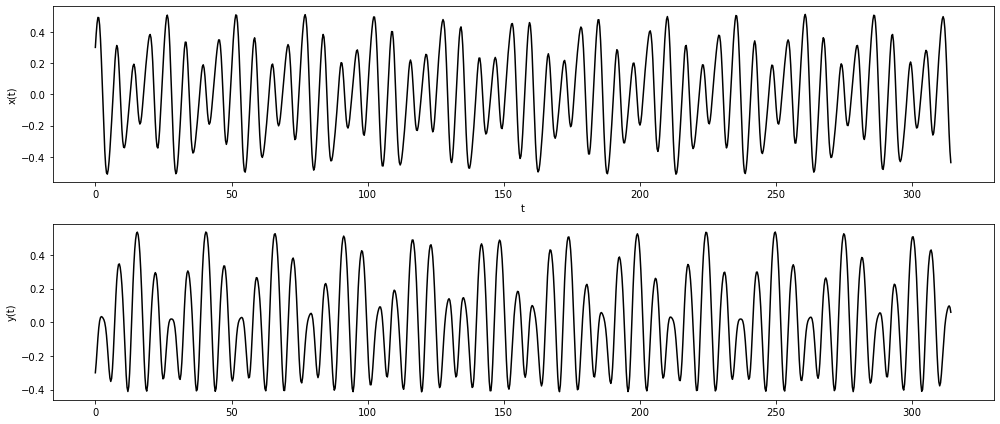

In [5]:
# lines = loadtxt("filename.dat", comments="#", delimiter=",", unpack=False)
tdata = loadtxt("data/HenonHeiles/t.dat")
xdata = loadtxt("data/HenonHeiles/x.dat")
ydata = loadtxt("data/HenonHeiles/y.dat")

N = len(tdata)
print("The time series consist of ", N, " points.")

plt.figure(figsize=(14,6))
plt.subplot(2,1,1)
plt.plot(tdata,xdata,'k')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.subplot(2,1,2)
plt.plot(tdata,ydata,'k')
plt.ylabel('y(t)')
plt.tight_layout()



#### Short range forecast

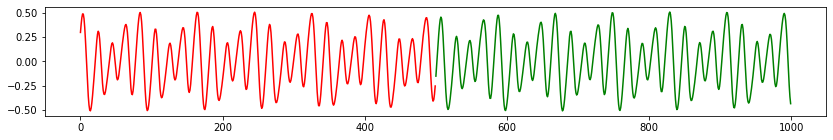

In [6]:
trainlen = int(0.8*N)
testlen  = int(0.2*N)
trainlen = int(0.5*N)
testlen  = int(0.5*N)


# Input  data equivalents:
#ttrain = np.ones(trainlen)
#ttest=np.ones(testlen)

# ttrain = tdata[:trainlen]
# ttest  = tdata[trainlen:trainlen+testlen]

ytrain = ydata[:trainlen]
ytest  = ydata[trainlen:trainlen+testlen]

# Output data
xtrain = xdata[:trainlen]
xtest = xdata[trainlen:trainlen+testlen]

plt.figure(figsize=(14,2))

plt.plot(range(0,trainlen), xtrain,'r')
plt.plot(range(trainlen,trainlen+testlen), xtest,'-g')
# plt.plot(ttrain, xtrain,'b')
# plt.plot(ttest, xtest,'-r')

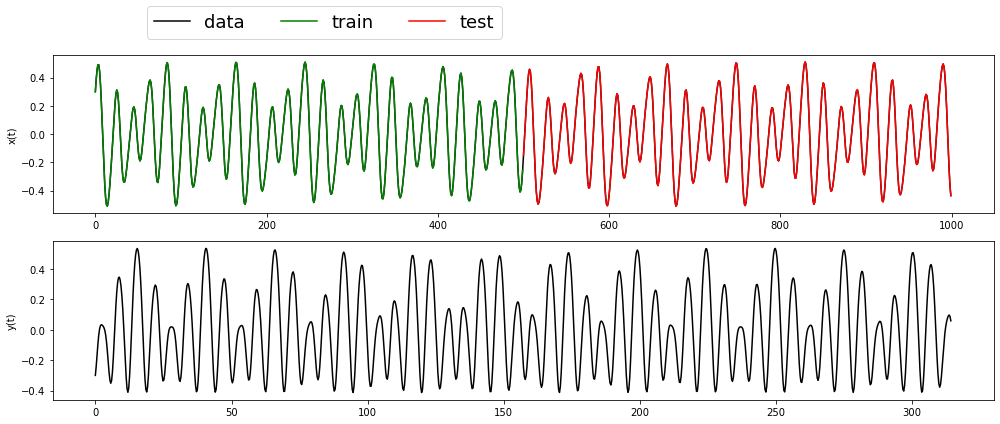

In [7]:
plt.figure(figsize=(14,6))
plt.subplot(2,1,1)
plt.plot(range(0,trainlen+testlen),xdata,'k',label='data')
plt.plot(range(0,trainlen), xtrain,'g',label='train')
plt.plot(range(trainlen,trainlen+testlen), xtest,'-r',label='test')
plt.ylabel('x(t)')
plt.legend(loc=(0.1,1.1),fontsize=18,ncol=3)
plt.subplot(2,1,2)
plt.plot(tdata,ydata,'k')
plt.ylabel('y(t)')
plt.tight_layout()


plt.tight_layout()

# RcTorch pure prediction

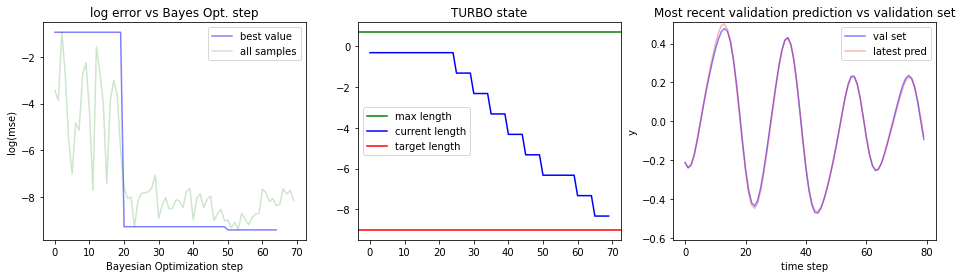

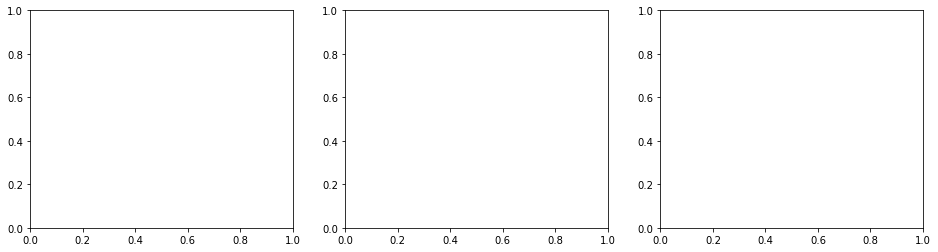

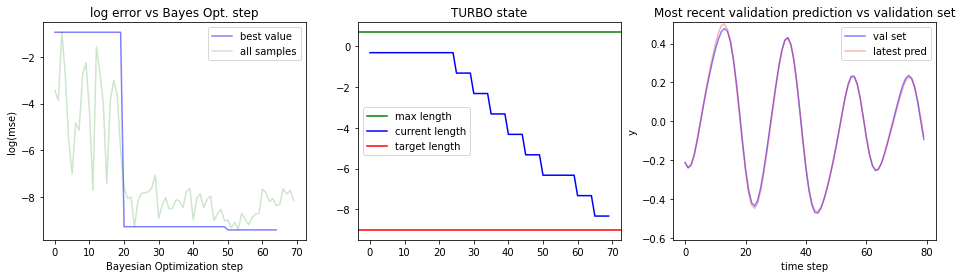

In [8]:
#declare the bounds dict. See above for which variables are optimized in linear vs logarithmic space.
bounds_dict = {"connectivity" : (-1, -0.1), 
               "spectral_radius" : (1, 2),
               "n_nodes" : 1000,
               "regularization" : (-3, 3),
               "leaking_rate" : (0, 1),
               #"input_scaling" : (0, 1),
               #"feedback_scaling" : (0, 1),
               "bias": (0,1)
               }

#declare the esn_cv optimizer: this class will run bayesian optimization to optimize the bounds dict.

esn_cv = EchoStateNetworkCV(bounds = bounds_dict, esn_feedback = True, 
                            scoring_method = "mse", interactive = True, 
                            batch_size = 5, cv_samples = 4, initial_samples = 20, 
                            subsequence_length = int(ytrain.shape[0] * 0.8),
                            random_seed = 209, success_tolerance = 10)
#optimize:
optimized_hyper_params = esn_cv.optimize(y =xtrain.reshape(-1,1))

In [9]:
optimized_hyper_params

{'n_nodes': 1000,
 'connectivity': 0.166936607791533,
 'spectral_radius': 1.4345366954803467,
 'regularization': 0.612374849074496,
 'leaking_rate': 0.464394748210907,
 'bias': 0.012337559834122658}

Training mean square error:  0.0035879122942383502
Testing  mean square error:  0.03664586806823868


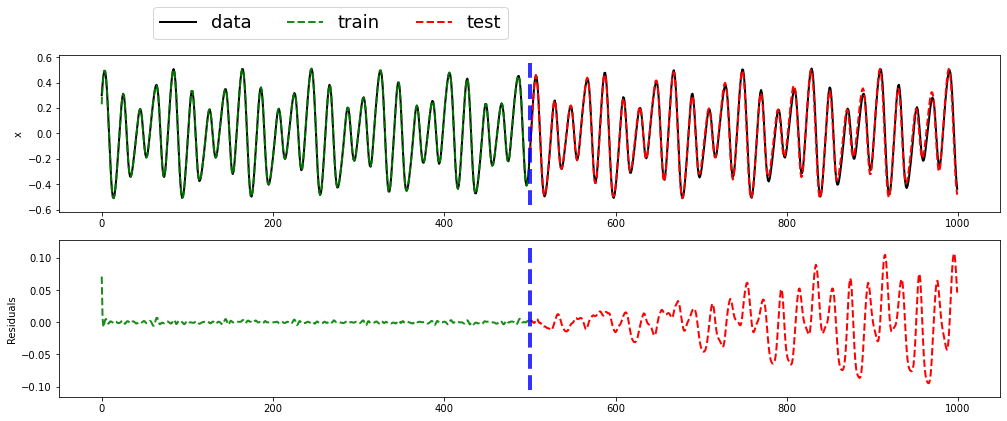

In [10]:
esn = EchoStateNetwork(**optimized_hyper_params, random_state = 209, feedback = 1)
xfit = esn.train(y = xtrain)
xfit = xfit.reshape(-1)
scoreTest, xhat = esn.test(y = xtest.reshape(-1,1))


# MSE in the training and testing
scoreTrain = myMSE(xfit,xtrain)
scoreTest = myMSE(xhat,xtest)
print("Training mean square error: ",scoreTrain)
print("Testing  mean square error: ",scoreTest)

# Residuals 
resTrain = residuals(xfit, xtrain);
resTest = residuals(xhat, xtest);

# Plot:
plotResults(trainlen, testlen, xdata, xfit, xhat, resTrain, resTest)

#### Long range forecast (inference)

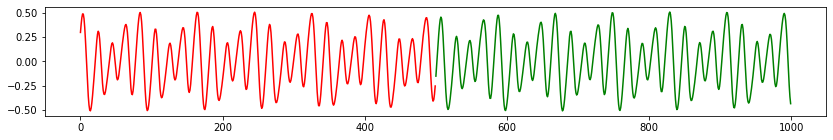

In [11]:
trainlen = int(0.5*N)
testlen  = int(0.5*N)

# Input  data
ttrain = np.ones(trainlen)
ttest=np.ones(testlen)

ytrain = ydata[:trainlen]
ytest  = ydata[trainlen:trainlen+testlen]

# Output data
xtrain = xdata[:trainlen]
xtest = xdata[trainlen:trainlen+testlen]


plt.figure(figsize=(14,2))
plt.plot(range(0,trainlen), xtrain,'r')
plt.plot(range(trainlen,trainlen+testlen), xtest,'-g')
# plt.plot(ttrain, xtrain,'b')
# plt.plot(ttest, xtest,'-r')

## RcTorch Observers Solution

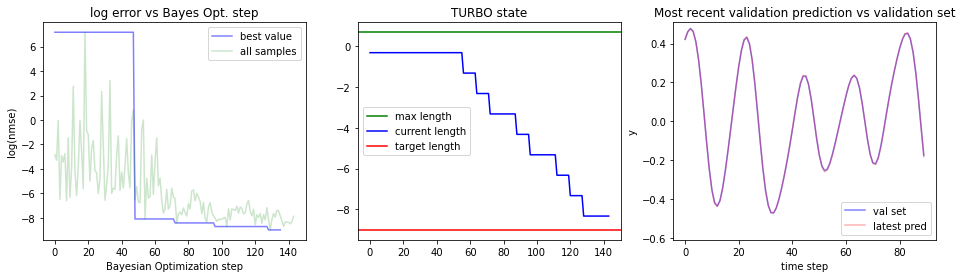

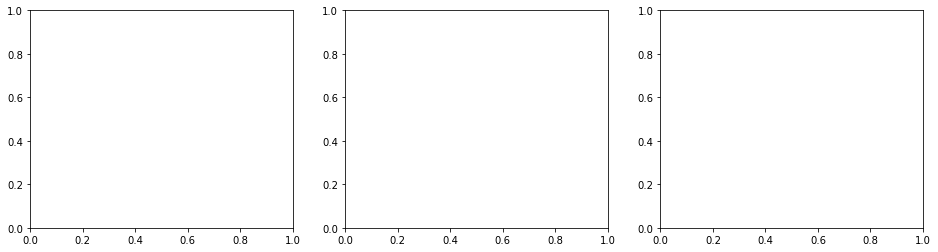

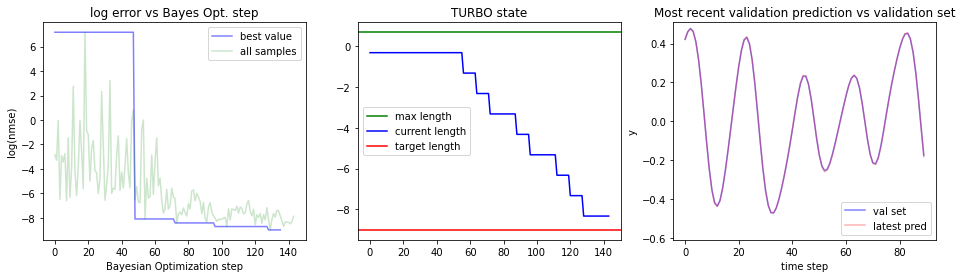

In [13]:
bounds_dict = {"connectivity" : (-1, -0.1), 
               "spectral_radius" : (1, 2),
               "n_nodes" : 1000,
               "regularization" : (-3, 3),
               "leaking_rate" : (0, 1),
               #"input_scaling" : (0, 1),
               #"feedback_scaling" : (0, 1),
               "bias": (0,1)
               }
esn_cv = EchoStateNetworkCV(bounds = bounds_dict, esn_feedback = True, 
                            scoring_method = "nmse", interactive = True, 
                            batch_size = 8, cv_samples = 2, initial_samples = 50, 
                            subsequence_length = int(ytrain.shape[0] * 0.9),
                            random_seed = 123)
optimized_hyper_params = esn_cv.optimize(y = xtrain.reshape(-1,1), x = ytrain.reshape(-1,1))

Training mean square error:  0.002300682646732996
Testing  mean square error:  0.013646447198484072


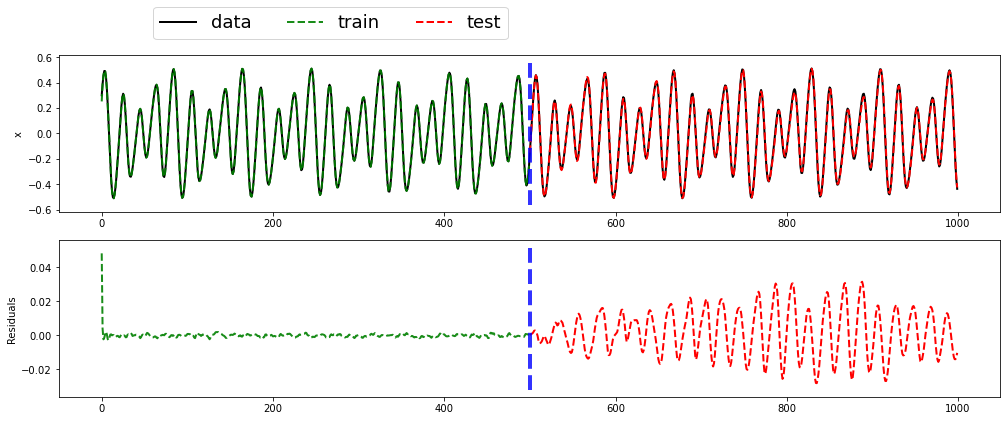

In [14]:
esn = EchoStateNetwork(**optimized_hyper_params, random_state = 123, feedback = 1)
xfit = esn.train(y = xtrain, X = ytrain)
xfit = xfit.reshape(-1)
#scoreTrain, yfit = esn.test(y = ytrain)
scoreTest, xhat = esn.test(y = xtest, x = ytest)

# MSE in the training and testing
scoreTrain = myMSE(xfit, xtrain)
scoreTest = myMSE(xhat, xtest)
print("Training mean square error: ",scoreTrain)
print("Testing  mean square error: ",scoreTest)

# Residuals 
resTrain = residuals(xfit,xtrain);
resTest = residuals(xhat,xtest);

# Plot:
plotResults(trainlen, testlen, xdata, xfit, xhat, resTrain, resTest)